In [1]:
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import scipy.stats as stats

In [2]:
df = pd.read_csv('iso.csv')
df = df[df['r1_charge_heater'] >= 0]

min_yield = 98
min_ron = 83

valid_comb_ix = (df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)

# Random Experimentation

In [3]:
def build_trace(df, chosen_ixs, min_ron, min_yield):
    
    traced_ch = df.iloc[chosen_ixs]['r1_charge_heater']
    traced_ron = df.iloc[chosen_ixs]['process_ron']
    traced_yield = df.iloc[chosen_ixs]['process_yield']
    
    feasibles_ix = (traced_ron >= min_ron) & (traced_yield >= min_yield)
    
    adjusted_ch = traced_ch * feasibles_ix + (1-feasibles_ix) * -1
    adjusted_ch[adjusted_ch==-1]=np.inf
    
    best_ch = nanmin_accumulate(adjusted_ch)
    return best_ch, feasibles_ix

def nanmin_accumulate(vals):
    acc = []
    min_val = float("inf")
    for val in vals:
        if val < min_val:
            min_val = val
        acc.append(min_val)
    return acc 
N_EXPS = 500
N_REPS = 100

traces = []
f_traces = []
for r in range(N_REPS):
    random_ix = rng.permutation(df.shape[0])[:N_EXPS]
    best_ch, feasibles_ix = build_trace(df, random_ix, min_ron, min_yield)
    traces.append(best_ch)
    f_traces.append(feasibles_ix)

avg_best_random = np.mean(traces, axis=0)

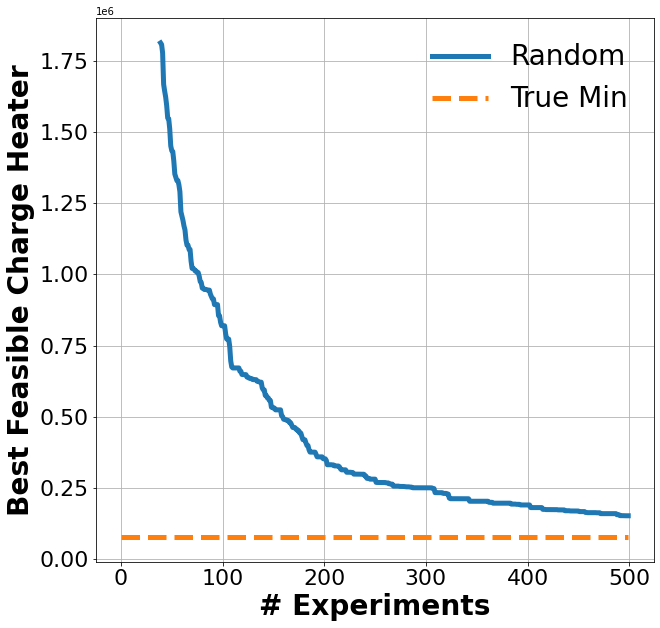

In [4]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(np.arange(avg_best_random.shape[0]), avg_best_random, linewidth=5, label='Random')
ax.plot(np.arange(avg_best_random.shape[0]), np.ones(avg_best_random.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater']), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best Feasible Charge Heater', fontsize=28, fontweight='bold')
ax.grid(True)
ax.legend(fontsize=28, frameon=False)

# Stochastic NN

In [6]:
class StochasticNN:
    
    def __init__(self, cfg):
        self._cfg = cfg 
        
        
    def train(self, Xtrain, Ytrain):
        
        self._make_model()
        
        # normalize X and y train
        Xtrain = stats.zscore(Xtrain, axis=0, ddof=1)
        Ytrain_mu = np.mean(Ytrain, axis=0, keepdims=True)
        Ytrain_std = np.std(Ytrain, axis=0, ddof=1, keepdims=True)
        Ytrain = (Ytrain - Ytrain_mu) / Ytrain_std
        
        self._Ytrain_mu = Ytrain_mu
        self._Ytrain_std = Ytrain_std
        
        history = self._model.fit(Xtrain, 
                                  Ytrain, 
                                  batch_size=Xtrain.shape[0]//10, 
                                  epochs=self._cfg['n_epochs'], 
                                  verbose=self._cfg['verbose'])
        
    def _make_model(self):
        cfg = self._cfg 
        
        keras.backend.clear_session()
    
        input_layer = keras.layers.Input(shape=(cfg['n_input'],))
        hidden_layer = keras.layers.Dense(cfg['n_hidden'], activation='tanh')(input_layer)
        dropout1_layer = keras.layers.Dropout(0.5)(hidden_layer, training=True)
        output_layer = keras.layers.Dense(cfg['n_output'], activation='linear')(dropout1_layer)
        
        model = keras.Model(input_layer, output_layer)
        model.compile(
            loss=keras.losses.MeanAbsoluteError(),
            optimizer=keras.optimizers.Nadam()
        )
        #print(model.summary())
        self._model = model 
    
    def predict(self, X, n_samples=2):
        
        X = stats.zscore(X, axis=0, ddof=1)
        
        samples = []
        for i in range(n_samples):
            preds = self._model.predict(X) * self._Ytrain_std + self._Ytrain_mu 
            samples.append(preds)
        
        samples = np.array(samples)
        return samples

In [8]:

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])

min_ron = 83
min_yield = 98

N_INIT_SAMPLES = 10
N_SAMPLES_TO_DRAW = 50
N_PRED_SAMPLES=20
N_EPOCHS = 50
REPS = 20

nn = StochasticNN({ "n_input" : 4, "n_output" : 3, "n_hidden" : 5, "n_epochs" : N_EPOCHS, "verbose" : False })

bo_traces = []
for r in range(REPS):
    
    # pick random points to seed the model
    chosen_ix = rng.choice(X.shape[0], N_INIT_SAMPLES, replace=False).tolist()
    
    # keep track of available experiments to run
    avail_indecies = np.ones(X.shape[0]).astype(bool)
    avail_indecies[chosen_ix] = False 
    
    print("Rep %d" % r)
    while len(chosen_ix) < N_SAMPLES_TO_DRAW:
        #print("%r %d " % (r, len(chosen_ix)))
        # train model
        Xtrain = X[chosen_ix, :]
        Ytrain = Y[chosen_ix, :]
        print(" Latest obs: %s" % Ytrain[-1,:])
        nn.train(Xtrain, Ytrain)
        
        # sample predictions
        pred_samples = nn.predict(X, n_samples=N_PRED_SAMPLES)
        
        # gather those at the chosen locations
        pred_samples_training = pred_samples[:,chosen_ix,:]
        pred_mean_ch_training = np.mean(pred_samples_training[:,:,0], axis=0)
        best_ch = np.min(pred_mean_ch_training)
        
        # compute the probability of feasible improvement
        prob_goodness = np.mean((pred_samples[:,:,0] < best_ch) & (pred_samples[:,:,1] >= min_ron) & (pred_samples[:,:,2] >= min_yield), axis=0)
        prob_goodness[chosen_ix] = 0
        
        #print("Max prob goddness: %0.2f" % np.max(prob_goodness))
        # choose next point
        ix = rng.permutation(prob_goodness.shape[0])
        next_ix = max(ix, key=lambda i: prob_goodness[i])
        chosen_ix.append(next_ix)
    
    bo_traces.append(chosen_ix)

Rep 0
 Latest obs: [2.28673013e+06 8.42010226e+01 9.63901121e+01]
 Latest obs: [4.43426402e+06 8.19195125e+01 1.00133594e+02]
 Latest obs: [7.52791586e+06 8.08718656e+01 9.96497600e+01]
 Latest obs: [7.19806436e+06 8.43241647e+01 9.58073902e+01]
 Latest obs: [1.91766175e+06 8.36271639e+01 9.76009935e+01]
 Latest obs: [3.87464131e+06 8.17485477e+01 1.00158352e+02]
 Latest obs: [6.23207349e+06 8.23097378e+01 9.96224175e+01]
 Latest obs: [7.36574093e+05 8.29355868e+01 9.87526986e+01]
 Latest obs: [9.44026812e+06 8.40234122e+01 9.60427525e+01]
 Latest obs: [1.84048979e+06 8.34696908e+01 9.79231486e+01]
 Latest obs: [2.06802539e+06 8.37606205e+01 9.73371331e+01]
 Latest obs: [4.37732988e+05 8.24416175e+01 9.96346846e+01]
 Latest obs: [1.69247140e+06 8.41277365e+01 9.64354550e+01]
 Latest obs: [1.23531119e+05 8.28586468e+01 9.87485579e+01]
 Latest obs: [1.54965084e+06 8.38554526e+01 9.70312712e+01]
 Latest obs: [7.03163826e+05 8.26206016e+01 9.93480570e+01]
 Latest obs: [9.95838155e+05 8.251

In [10]:
bo_ch_traces = []
bo_f_traces = []
for chosen_ix in bo_traces:
    print(chosen_ix)
    best_ch, feasibles_ix = build_trace(df, chosen_ix, min_ron, min_yield)
    bo_ch_traces.append(best_ch)
    bo_f_traces.append(feasibles_ix)

avg_best_bo = np.mean(bo_ch_traces, axis=0)
np.mean(bo_f_traces, axis=0)
avg_best_bo

[2090, 4971, 4490, 5084, 1339, 4086, 535, 2217, 4725, 4366, 613, 4060, 3660, 1258, 592, 457, 2355, 1472, 3, 1897, 1773, 4360, 2393, 5916, 2916, 1595, 3155, 78, 5834, 2389, 99, 399, 45, 6332, 5848, 728, 5754, 5765, 5818, 6339, 4251, 470, 1167, 1774, 6523, 2857, 2338, 4936, 2376, 2465]
[1851, 5929, 2946, 3348, 4607, 4625, 878, 955, 1608, 5967, 2257, 3288, 2831, 2465, 3088, 2438, 2581, 3115, 6661, 2447, 4905, 620, 1317, 5938, 2729, 6467, 1979, 173, 4665, 1922, 1304, 5790, 191, 3140, 5076, 3135, 160, 3155, 731, 2471, 4718, 4258, 6361, 699, 717, 5903, 5075, 2364, 4362, 2410]
[240, 3592, 1426, 3483, 2151, 308, 4223, 6637, 2512, 6304, 2345, 5723, 4092, 763, 4435, 1246, 796, 2392, 113, 2822, 97, 5865, 2766, 1248, 160, 6580, 81, 5866, 2591, 540, 5835, 5822, 2645, 5248, 1275, 2516, 794, 5777, 5025, 5079, 2427, 5618, 1259, 801, 1837, 1648, 1319, 33, 5905, 3014]
[2225, 4016, 1037, 5567, 2369, 2905, 3040, 3046, 2837, 3484, 2053, 286, 2169, 5652, 3792, 5641, 5874, 6566, 5180, 4246, 4994, 6006, 3458,

array([             inf,              inf,              inf,
                    inf,              inf,              inf,
                    inf,              inf,              inf,
                    inf, 3977566.40627605, 2988903.67119243,
       2988903.67119243, 2664937.29656443, 2282239.57336956,
       2282239.57336956, 2282239.57336956, 2165880.8046128 ,
       2165880.8046128 , 2165880.8046128 , 2165880.8046128 ,
       1955866.26858221, 1933225.80919809, 1933225.80919809,
       1898491.78735989, 1898491.78735989, 1302004.53675208,
        923154.92209418,  803610.25628039,  773495.90634646,
        773495.90634646,  773495.90634646,  571835.26361957,
        517869.54923206,  517869.54923206,  517869.54923206,
        412673.71272541,  412673.71272541,  350157.30318267,
        350157.30318267,  350157.30318267,  350157.30318267,
        350157.30318267,  350157.30318267,  350157.30318267,
        350157.30318267,  350157.30318267,  350157.30318267,
        350157.30318267,

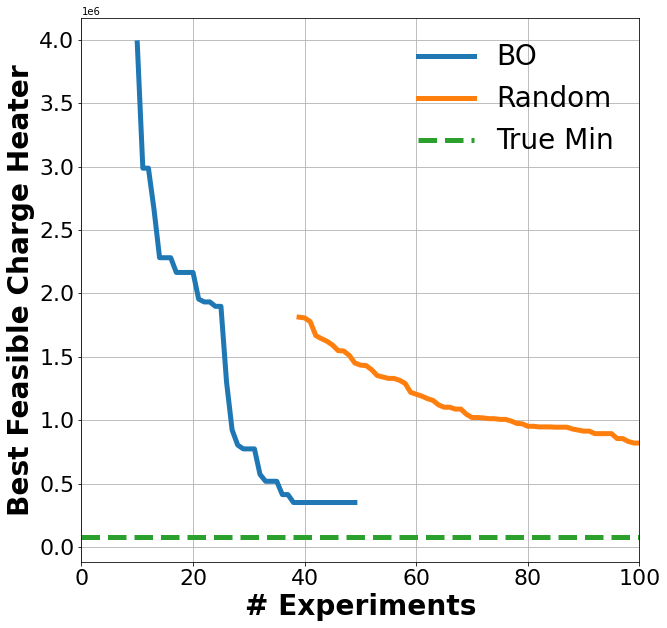

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(np.arange(avg_best_bo.shape[0]), avg_best_bo, linewidth=5, label='BO')
ax.plot(np.arange(avg_best_random.shape[0]), avg_best_random, linewidth=5, label='Random')
ax.plot(np.arange(avg_best_random.shape[0]), np.ones(avg_best_random.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater']), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best Feasible Charge Heater', fontsize=28, fontweight='bold')
ax.set_xlim([0, 100])
ax.grid(True)
ax.legend(fontsize=28, frameon=False)